# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
# Import libraries
import os
import numpy as np
import tqdm # For showing the progress

# Pytorch
import torch
# Dataset
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
# Model, training
from torch import nn
from torch import optim
import torch.nn.functional as F

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# data_dir = '/data/landmark_images/'
# data_dir = 'C:/Users/BensonHuang/Downloads/landmark_images'
data_dir = '/home/BensonHuang/ml/landmark_images'
#
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# Check if the mentioned path exist
print("Path exist: ", os.path.exists(data_dir), "\n--------------------\n")

# Show the directory tree
#---------------------------------------------#
# Ref.: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath, print_files=True):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        dir_name = os.path.basename(root)
        print('{}{}/{}[# sub-dirs: {}, # files: {}]'.format(indent, dir_name, ' '*max(50-len(dir_name), 1), len(dirs), len(files)))
        subindent = ' ' * 4 * (level + 1)
        if print_files:
            for f in files:
                print('{}{}'.format(subindent, f))
            
# print(list_files(data_dir, print_files=False))
#---------------------------------------------#


# The function for getting data loaders
def get_data_loaders(train_valid_dir, test_dir, 
                     transform=transforms.ToTensor(), 
                     batch_size=20, 
                     num_workers=0, 
                     valid_size=0.2, 
                     seed=42):
    '''
    This is the function for generating data loaders from image data paths 
    for training, validation, and testing, repectively.
    '''
    
    # load and transform data using ImageFolder
    #-------------------------------------#
    train_valid_data = datasets.ImageFolder(train_valid_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # print out some data stats
    print('Num training/validation images: ', len(train_valid_data))
    print('Num test images: ', len(test_data))
    #-------------------------------------#

    # obtain training indices that will be used for validation
    num_train_valid = len(train_valid_data)
    indices = list(range(num_train_valid))
    # Set a fixed seed so that the validation set is the same every time I run the script.
    np.random.seed(seed) 
    np.random.shuffle(indices)
    #
    split = int(np.floor(valid_size * num_train_valid))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_valid_data, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_valid_data, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=False)
    #-------------------------------------#

    return train_valid_data, test_data, {'train': train_loader, 'valid': valid_loader, 'test': test_loader} 


# Generate the data loaders
#------------------------------------------------------------#

# Data transform
#-----------------------------#
# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = 32 # LeNet: 32 # 224
# data_transform = transforms.ToTensor()
data_transform = transforms.Compose([transforms.RandomResizedCrop(image_size), 
                                      transforms.ToTensor()])
#-----------------------------#
# define dataloader parameters
batch_size = 20
num_workers=0
valid_size = 0.2 # percentage of the dataset to be used for validation

# Generate the data loaders by calling the function
train_valid_data, test_data, loaders_scratch = get_data_loaders(train_dir, test_dir,
                                                                transform=data_transform,
                                                                batch_size=batch_size, 
                                                                num_workers=num_workers, 
                                                                valid_size=valid_size, 
                                                                seed=42)


Path exist:  True 
--------------------

Num training/validation images:  4996
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- The resizing is done by utilizing the transforms.RandomResizedCrop method, which crops the image at a random location (within a given area scale ratio) and random aspect ratio before resizing to the asked size output (32x32 here). Since the aspect ratio for cropping is not a fixed value as the one of the asked shape, the image will be randomly stretched. 
- The image shape for the network input is designed to be 32x32, which is the input shape for that the original LeNet-5 asked. Although the resolution is somewhat low for a human to see, the result still meets the requirement.
- There is a light augmentation applied to the dataset via transforms.RandomResizedCrop, which guides the network about the invariances in translation, scale, and aspect ratio. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

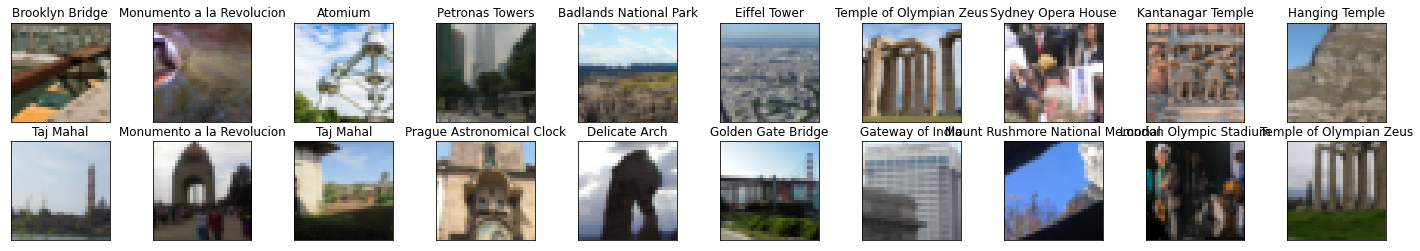

In [3]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes_raw = train_valid_data.classes
classes = [' '.join(_c[3:].split('_')) for _c in classes_raw] # Remove the number and replace the '_' by space
num_classes = len(classes)
print(classes_raw)
print()
print("Totally <%d> classes" % num_classes)
print()
# print(classes)
for _i, _c in enumerate(classes):
    print("%2d: %s" % (_i, _c))


# Visualize some training data
# obtain one batch of training images
dataiter = iter( loaders_scratch['train'] )
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

print(f'\nimages[0,0,0,0] = {images[0,0,0,0]}\n')

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0))) # (c,h,w) --> (h,w,c)
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(f'{use_cuda = }')

use_cuda = True


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() # For scores output
# criterion_scratch = nn.NLLLoss() # For log probabilities output

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0001)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
# # define the CNN architecture (LeNet5)
# class Net(nn.Module):
#     ## TODO: choose an architecture, and complete the class
#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## Define layers of a CNN
#         self.conv11 = nn.Conv2d(3,  6, 5, padding=0) # 32x32-->28x28
#         # pool
#         self.conv21 = nn.Conv2d(6, 16, 5, padding=0) # 14x14-->10x10
#         # pool
         
#         # FC
#         self.fc1 = nn.Linear(16*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)

#         # self.max_pool = nn.MaxPool2d(2,2)
#         self.avg_pool = nn.AvgPool2d(2,2)
#         # self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         ## Define forward behavior
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.avg_pool(x))        
#         x = F.relu(self.conv21(x))
#         x = F.relu(self.avg_pool(x))        
#         # Flatten
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = self.dropout(x) # Dropout
#         x = self.fc3(x) # Scores output
#         # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
#         return x

# # define the CNN architecture (ver.2: increase the layer width)
# class Net(nn.Module):
#     ## TODO: choose an architecture, and complete the class
#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## Define layers of a CNN
#         self.conv11 = nn.Conv2d(3,  18, 5, padding=0) # 32x32-->28x28
#         # pool
#         self.conv21 = nn.Conv2d(18, 48, 5, padding=0) # 14x14-->10x10
#         # pool
         
#         # FC
#         self.fc1 = nn.Linear(48*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)

#         # self.max_pool = nn.MaxPool2d(2,2)
#         self.avg_pool = nn.AvgPool2d(2,2)
#         # self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         ## Define forward behavior
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.avg_pool(x))        
#         x = F.relu(self.conv21(x))
#         x = F.relu(self.avg_pool(x))        
#         # Flatten
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = self.dropout(x) # Dropout
#         x = self.fc3(x) # Scores output
#         # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
#         return x

# define the CNN architecture (ver.3 increase the width further more)
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv11 = nn.Conv2d(3,  36, 5, padding=0) # 32x32-->28x28
        # pool 28x28-->14x14
        self.conv21 = nn.Conv2d(36, 96, 5, padding=0) # 14x14-->10x10
        # pool 10x10-->5x5
         
        # FC
        self.fc1 = nn.Linear(96*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # self.max_pool = nn.MaxPool2d(2,2)
        self.avg_pool = nn.AvgPool2d(2,2)
        # self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv11(x))
        x = F.relu(self.avg_pool(x))        
        x = F.relu(self.conv21(x))
        x = F.relu(self.avg_pool(x))        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.dropout(x) # Dropout
        x = self.fc3(x) # Scores output
        # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
        return x

    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

The base architecture I chose is LeNet-5 (https://ieeexplore.ieee.org/document/726791) proposed by Yann LeCun et.al. while most of the designed were simplified: activations changes to ReLUs, feature maps between convolusion layers are fully connected, and the output is the "score" for the softmax activation.
- In version 1, beside the simplification, the input image shape is also change to (32,32,3) for color images. It reached the accuracy about 14%.
- In version 2, I tripled the numbers of feature maps in conv1 and conv2 because of the thought of that the original LeNet-5 designed for the gray image of 1 channel may not be sufficient to contain color features. It reached the accuracy about 18%.
- In version 3, I keep increasing the numbers of feature maps by doubling them. It turns out to reach the accuracy of 22%.

During each version, I tried increasing the depth of comvolution layers or adding dropout at final stage; however, they didn't work in this case.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    valid_loss_min_epoch = -1
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm.tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Update the train_loss
            train_loss = 1./(batch_idx+1) * (batch_idx*train_loss + loss.data.item())

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            # Update the valid_loss
            valid_loss = 1./(batch_idx+1) * (batch_idx*valid_loss + loss.data.item())

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            valid_loss_min_epoch = epoch
            torch.save(model.state_dict(), save_path)   
            print("Model saved.")
        
        # Early stopping
        patience = 5 # 5
        stop_th = 0.05 # 5%
        if (epoch - valid_loss_min_epoch) > patience:
            print("Out of patience, consider to stop.")
            # Stop the training if the current loss is greater than the threshold, or just keep the training 
            if (valid_loss - valid_loss_min) > (stop_th * valid_loss_min): # stop_th is represented as a ratio
                print("The validation loss jumped across the threshold, stop.")
                break
            else:
                print("The validation loss is not quit big, keep watching")
            
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # print("classname = %s" % str(classname))
    # print("classname.find('Linear') = %s" % str(classname.find("Linear")))
    if classname.find("Linear") != -1:
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.normal_(mean=0.0, std=y)
        m.bias.data.fill_(0.0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:45<00:00,  4.44it/s]


Epoch: 1 	Training Loss: 3.908223 	Validation Loss: 3.897179
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.19it/s]


Epoch: 2 	Training Loss: 3.870738 	Validation Loss: 3.834364
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.02it/s]


Epoch: 3 	Training Loss: 3.811674 	Validation Loss: 3.765652
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.41it/s]


Epoch: 4 	Training Loss: 3.753195 	Validation Loss: 3.733508
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.99it/s]


Epoch: 5 	Training Loss: 3.710717 	Validation Loss: 3.699230
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.18it/s]


Epoch: 6 	Training Loss: 3.680508 	Validation Loss: 3.667011
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.06it/s]


Epoch: 7 	Training Loss: 3.643938 	Validation Loss: 3.641883
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.28it/s]


Epoch: 8 	Training Loss: 3.629884 	Validation Loss: 3.644528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.87it/s]


Epoch: 9 	Training Loss: 3.603374 	Validation Loss: 3.591073
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.97it/s]


Epoch: 10 	Training Loss: 3.577382 	Validation Loss: 3.580673
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.62it/s]


Epoch: 11 	Training Loss: 3.554695 	Validation Loss: 3.569942
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.91it/s]


Epoch: 12 	Training Loss: 3.515871 	Validation Loss: 3.557272
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.00it/s]


Epoch: 13 	Training Loss: 3.494804 	Validation Loss: 3.511161
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch: 14 	Training Loss: 3.484273 	Validation Loss: 3.547318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.82it/s]


Epoch: 15 	Training Loss: 3.470126 	Validation Loss: 3.498979
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.28it/s]


Epoch: 16 	Training Loss: 3.442890 	Validation Loss: 3.491961
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.16it/s]


Epoch: 17 	Training Loss: 3.435082 	Validation Loss: 3.490338
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.38it/s]


Epoch: 18 	Training Loss: 3.414710 	Validation Loss: 3.472808
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.08it/s]


Epoch: 19 	Training Loss: 3.402667 	Validation Loss: 3.483447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.20it/s]


Epoch: 20 	Training Loss: 3.382453 	Validation Loss: 3.456092
Model saved.


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.65it/s]


Epoch: 1 	Training Loss: 3.912833 	Validation Loss: 3.906197
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.90it/s]


Epoch: 2 	Training Loss: 3.881342 	Validation Loss: 3.858314
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.54it/s]


Epoch: 3 	Training Loss: 3.821594 	Validation Loss: 3.789922
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.68it/s]


Epoch: 4 	Training Loss: 3.764159 	Validation Loss: 3.811197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.19it/s]


Epoch: 5 	Training Loss: 3.728346 	Validation Loss: 3.696395
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.05it/s]


Epoch: 6 	Training Loss: 3.680239 	Validation Loss: 3.667695
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.29it/s]


Epoch: 7 	Training Loss: 3.658001 	Validation Loss: 3.665905
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.95it/s]


Epoch: 8 	Training Loss: 3.646737 	Validation Loss: 3.654541
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.34it/s]


Epoch: 9 	Training Loss: 3.618736 	Validation Loss: 3.600589
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.21it/s]


Epoch: 10 	Training Loss: 3.619841 	Validation Loss: 3.634424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.88it/s]


Epoch: 11 	Training Loss: 3.593370 	Validation Loss: 3.635839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch: 12 	Training Loss: 3.583562 	Validation Loss: 3.622325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch: 13 	Training Loss: 3.573201 	Validation Loss: 3.619412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch: 14 	Training Loss: 3.564891 	Validation Loss: 3.589586
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.24it/s]


Epoch: 15 	Training Loss: 3.564346 	Validation Loss: 3.580181
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.20it/s]


Epoch: 16 	Training Loss: 3.542501 	Validation Loss: 3.566043
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch: 17 	Training Loss: 3.542432 	Validation Loss: 3.547213
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.52it/s]


Epoch: 18 	Training Loss: 3.519398 	Validation Loss: 3.545807
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.24it/s]


Epoch: 19 	Training Loss: 3.515243 	Validation Loss: 3.570731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.19it/s]


Epoch: 20 	Training Loss: 3.518670 	Validation Loss: 3.533735
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.13it/s]


Epoch: 21 	Training Loss: 3.495159 	Validation Loss: 3.513954
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.92it/s]


Epoch: 22 	Training Loss: 3.496092 	Validation Loss: 3.552065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.47it/s]


Epoch: 23 	Training Loss: 3.495794 	Validation Loss: 3.522603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.32it/s]


Epoch: 24 	Training Loss: 3.479265 	Validation Loss: 3.529652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.11it/s]


Epoch: 25 	Training Loss: 3.483435 	Validation Loss: 3.514150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.09it/s]


Epoch: 26 	Training Loss: 3.463399 	Validation Loss: 3.521822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.11it/s]


Epoch: 27 	Training Loss: 3.447335 	Validation Loss: 3.511925
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.81it/s]


Epoch: 28 	Training Loss: 3.464170 	Validation Loss: 3.531059


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.06it/s]


Epoch: 29 	Training Loss: 3.458036 	Validation Loss: 3.492932
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.10it/s]


Epoch: 30 	Training Loss: 3.448098 	Validation Loss: 3.498821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch: 31 	Training Loss: 3.428728 	Validation Loss: 3.505422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.96it/s]


Epoch: 32 	Training Loss: 3.407414 	Validation Loss: 3.485582
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch: 33 	Training Loss: 3.426374 	Validation Loss: 3.462007
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.06it/s]


Epoch: 34 	Training Loss: 3.402035 	Validation Loss: 3.457823
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.87it/s]


Epoch: 35 	Training Loss: 3.394581 	Validation Loss: 3.446489
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.12it/s]


Epoch: 36 	Training Loss: 3.393907 	Validation Loss: 3.458402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.18it/s]


Epoch: 37 	Training Loss: 3.382479 	Validation Loss: 3.449430


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.94it/s]


Epoch: 38 	Training Loss: 3.387548 	Validation Loss: 3.465862


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch: 39 	Training Loss: 3.388755 	Validation Loss: 3.424264
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.24it/s]


Epoch: 40 	Training Loss: 3.372873 	Validation Loss: 3.439271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch: 41 	Training Loss: 3.360936 	Validation Loss: 3.435352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.14it/s]


Epoch: 42 	Training Loss: 3.344009 	Validation Loss: 3.417080
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch: 43 	Training Loss: 3.334578 	Validation Loss: 3.390062
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch: 44 	Training Loss: 3.345240 	Validation Loss: 3.401229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch: 45 	Training Loss: 3.318570 	Validation Loss: 3.487655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch: 46 	Training Loss: 3.316094 	Validation Loss: 3.403642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch: 47 	Training Loss: 3.299854 	Validation Loss: 3.381025
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch: 48 	Training Loss: 3.295413 	Validation Loss: 3.383124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.96it/s]


Epoch: 49 	Training Loss: 3.277219 	Validation Loss: 3.340803
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.19it/s]


Epoch: 50 	Training Loss: 3.306574 	Validation Loss: 3.371706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.48it/s]


Epoch: 51 	Training Loss: 3.259598 	Validation Loss: 3.394309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.59it/s]


Epoch: 52 	Training Loss: 3.270042 	Validation Loss: 3.339608
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.08it/s]


Epoch: 53 	Training Loss: 3.226557 	Validation Loss: 3.350738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.14it/s]


Epoch: 54 	Training Loss: 3.234653 	Validation Loss: 3.348823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.42it/s]


Epoch: 55 	Training Loss: 3.233391 	Validation Loss: 3.332730
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.51it/s]


Epoch: 56 	Training Loss: 3.211744 	Validation Loss: 3.307550
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.41it/s]


Epoch: 57 	Training Loss: 3.228235 	Validation Loss: 3.329159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.28it/s]


Epoch: 58 	Training Loss: 3.217456 	Validation Loss: 3.323946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.42it/s]


Epoch: 59 	Training Loss: 3.213134 	Validation Loss: 3.313987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.76it/s]


Epoch: 60 	Training Loss: 3.194589 	Validation Loss: 3.304280
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch: 61 	Training Loss: 3.200125 	Validation Loss: 3.320124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch: 62 	Training Loss: 3.172339 	Validation Loss: 3.261797
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.23it/s]


Epoch: 63 	Training Loss: 3.197408 	Validation Loss: 3.271922


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.47it/s]


Epoch: 64 	Training Loss: 3.186262 	Validation Loss: 3.334051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch: 65 	Training Loss: 3.172340 	Validation Loss: 3.262001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.11it/s]


Epoch: 66 	Training Loss: 3.156299 	Validation Loss: 3.291516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.45it/s]


Epoch: 67 	Training Loss: 3.133640 	Validation Loss: 3.292821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.16it/s]


Epoch: 68 	Training Loss: 3.146519 	Validation Loss: 3.321508
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.15it/s]


Epoch: 69 	Training Loss: 3.164661 	Validation Loss: 3.244754
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.15it/s]


Epoch: 70 	Training Loss: 3.142746 	Validation Loss: 3.327661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.03it/s]


Epoch: 71 	Training Loss: 3.153439 	Validation Loss: 3.262384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.26it/s]


Epoch: 72 	Training Loss: 3.118610 	Validation Loss: 3.238476
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.65it/s]


Epoch: 73 	Training Loss: 3.108145 	Validation Loss: 3.272245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.22it/s]


Epoch: 74 	Training Loss: 3.110795 	Validation Loss: 3.271602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch: 75 	Training Loss: 3.124415 	Validation Loss: 3.242492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.49it/s]


Epoch: 76 	Training Loss: 3.120523 	Validation Loss: 3.217459
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.49it/s]


Epoch: 77 	Training Loss: 3.102635 	Validation Loss: 3.241516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.43it/s]


Epoch: 78 	Training Loss: 3.096861 	Validation Loss: 3.254150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.47it/s]


Epoch: 79 	Training Loss: 3.094445 	Validation Loss: 3.227144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  6.97it/s]


Epoch: 80 	Training Loss: 3.084399 	Validation Loss: 3.235042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch: 81 	Training Loss: 3.095014 	Validation Loss: 3.184728
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.50it/s]


Epoch: 82 	Training Loss: 3.071580 	Validation Loss: 3.202531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.20it/s]


Epoch: 83 	Training Loss: 3.084513 	Validation Loss: 3.230009


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.17it/s]


Epoch: 84 	Training Loss: 3.080896 	Validation Loss: 3.262024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch: 85 	Training Loss: 3.060730 	Validation Loss: 3.221132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.20it/s]


Epoch: 86 	Training Loss: 3.052363 	Validation Loss: 3.169930
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.06it/s]


Epoch: 87 	Training Loss: 3.044053 	Validation Loss: 3.218346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.16it/s]


Epoch: 88 	Training Loss: 3.033111 	Validation Loss: 3.240454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch: 89 	Training Loss: 3.053588 	Validation Loss: 3.230516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.23it/s]


Epoch: 90 	Training Loss: 3.026355 	Validation Loss: 3.165929
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.20it/s]


Epoch: 91 	Training Loss: 3.031345 	Validation Loss: 3.186025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.84it/s]


Epoch: 92 	Training Loss: 3.048365 	Validation Loss: 3.187735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch: 93 	Training Loss: 3.010869 	Validation Loss: 3.230802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.19it/s]


Epoch: 94 	Training Loss: 3.026870 	Validation Loss: 3.175939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch: 95 	Training Loss: 3.017673 	Validation Loss: 3.168107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch: 96 	Training Loss: 3.022459 	Validation Loss: 3.248573
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch: 97 	Training Loss: 3.004844 	Validation Loss: 3.226961
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch: 98 	Training Loss: 3.000384 	Validation Loss: 3.175914
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch: 99 	Training Loss: 2.988722 	Validation Loss: 3.214207
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.91it/s]


Epoch: 100 	Training Loss: 2.996856 	Validation Loss: 3.187008
Out of patience, consider to stop.
The validation loss is not quit big, keep watching


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(tqdm.tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.25it/s]

Test Loss: 3.186576


Test Accuracy: 20% (257/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Generate the data loaders
#------------------------------------------------------------#

# Data transform
#-----------------------------#
# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = 224 # For VGGNet
# data_transform = transforms.ToTensor()
data_transform = transforms.Compose([transforms.RandomResizedCrop(image_size), 
                                      transforms.ToTensor()])
#-----------------------------#
# define dataloader parameters
batch_size = 20
num_workers=0
valid_size = 0.2 # percentage of the dataset to be used for validation

# Generate the data loaders by calling the function
train_valid_data, test_data, loaders_transfer = get_data_loaders(train_dir, test_dir,
                                                                transform=data_transform,
                                                                batch_size=batch_size, 
                                                                num_workers=num_workers, 
                                                                valid_size=valid_size, 
                                                                seed=42)


# loaders_transfer = {'train': None, 'valid': None, 'test': None}


Num training/validation images:  4996
Num test images:  1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss() # For scores output


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [13]:
## TODO: Specify model architecture
print(torch.__version__)


def get_transfered_model():
    
    # model_transfer = models.vgg16(pretrained=True)
    model_transfer = models.resnet18(pretrained=True)
    
    # Freeze training for layers
    for param in model_transfer.parameters():
        param.requires_grad = False

    # Modify the fianl stage of the model
    model_transfer.fc = nn.Linear(512, num_classes)
    
    return model_transfer

# create the transfered model
model_transfer = get_transfered_model()
print(model_transfer)

# get the optimizer by passing in the appropriate parameter set
optimizer = get_optimizer_transfer(model_transfer.fc)
    
    

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

1.8.2+cu111


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/BensonHuang/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# train the model
num_epochs = 20
model_scratch = train(num_epochs, loaders_transfer, model_transfer, optimizer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:47<00:00,  1.19it/s]


Epoch: 1 	Training Loss: 2.893246 	Validation Loss: 2.055636
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]


Epoch: 2 	Training Loss: 1.840350 	Validation Loss: 1.640792
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:51<00:00,  1.16it/s]


Epoch: 3 	Training Loss: 1.522109 	Validation Loss: 1.541761
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:51<00:00,  1.17it/s]


Epoch: 4 	Training Loss: 1.390644 	Validation Loss: 1.393223
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch: 5 	Training Loss: 1.278781 	Validation Loss: 1.408167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]


Epoch: 6 	Training Loss: 1.216920 	Validation Loss: 1.343285
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch: 7 	Training Loss: 1.164856 	Validation Loss: 1.313642
Model saved.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:01<00:00,  1.10it/s]


Epoch: 8 	Training Loss: 1.129525 	Validation Loss: 1.378053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch: 9 	Training Loss: 1.098576 	Validation Loss: 1.355314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:54<00:00,  1.15it/s]


Epoch: 10 	Training Loss: 1.041345 	Validation Loss: 1.333681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch: 11 	Training Loss: 1.030368 	Validation Loss: 1.360619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]


Epoch: 12 	Training Loss: 1.016957 	Validation Loss: 1.313714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch: 13 	Training Loss: 1.003639 	Validation Loss: 1.398549
Out of patience, consider to stop.
The validation loss jumped across the threshold, stop.


<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
# Test
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:56<00:00,  1.12it/s]

Test Loss: 1.155444


Test Accuracy: 70% (877/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [19]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k, classes=classes, use_cuda=None):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # use cuda?
    if use_cuda is None:
        use_cuda = torch.cuda.is_available()
    
    # Load the model
    #---------------------------------------#
    # create the transfered model architecture (graph)
    model_transfer = get_transfered_model()
    
    # For pytorch version < 0.4.1
    if use_cuda:
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
#     # For pytorch version >= 0.4.1
#     device = torch.device("cuda:0" if use_cuda else "cpu")
#     map_location = device
    
    # Load the stored parameters
    model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location)) # Indicate the current device
    # Move the model to the desired devie
    if use_cuda:
        model_transfer = model_transfer.cuda()
    #---------------------------------------#
    
    # Pregenerate the data transform
    image_size = 224
    # data_transform = transforms.ToTensor()
#     data_transform = transforms.Compose([transforms.RandomResizedCrop(image_size), 
#                                          transforms.ToTensor()])
    data_transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                         transforms.ToTensor()])
    #
    
    # Load the image in query
    #---------------------------------------#
    image_raw = Image.open(img_path)
#     image_raw = np.asarray(Image.open(img_path))
#     image_raw = image_raw / 255.0
#     print(f'{image_raw[0,0,0]}')
#     print(f'{image_raw.shape}, {image_raw.dtype}')
    image_in = data_transform(image_raw)
#     print(f'{image_in.shape}')
    #---------------------------------------#
#     plt.imshow( image_raw ) # Sow the image
#     plt.imshow( image_in.permute(1,2,0) ) # Sow the image

    # Make a prediction using the model
    #---------------------------------------#
    if use_cuda:
        image_in = image_in.cuda()
    output = model_transfer(image_in[None,:])
    # print(F.softmax(output, dim=1))
    top_score, top_class = output.topk(k, dim=1)
#     print(f'top_class = {top_class}')
    top_classname = [classes[_idx] for _idx in top_class[0]]
#     print(f'{top_classname}')
    #---------------------------------------#
    return top_classname


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Stockholm City Hall',
 'Monumento a la Revolucion',
 'Great Wall of China',
 'Mount Rushmore National Memorial',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

This photo looks like being captured at Stockholm City Hall, Monumento a la Revolucion, or Great Wall of China. Which one is correct?


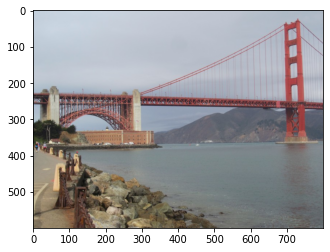

In [23]:
def suggest_locations(img_path, fig_id=0):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image_raw = Image.open(img_path)
    fig = plt.figure(fig_id)
    plt.imshow( image_raw ) # Sow the image
    print("This photo looks like being captured at {}, {}, or {}. Which one is correct?".format(*predicted_landmarks))

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

---
Image from <test_landmark_photos/grand_canyon_01.jpg>
This photo looks like being captured at Stockholm City Hall, Monumento a la Revolucion, or Mount Rushmore National Memorial. Which one is correct?
---
Image from <test_landmark_photos/grand_canyon_02.jpg>
This photo looks like being captured at Monumento a la Revolucion, Stockholm City Hall, or Mount Rushmore National Memorial. Which one is correct?
---
Image from <test_landmark_photos/gullfoss_falls_01.jpg>
This photo looks like being captured at Stockholm City Hall, Monumento a la Revolucion, or Great Wall of China. Which one is correct?
---
Image from <test_landmark_photos/sydney_harbor_bridge_01.jpg>
This photo looks like being captured at Monumento a la Revolucion, Stockholm City Hall, or Great Wall of China. Which one is correct?
---
Image from <test_landmark_photos/temple_of_olympian_zeus_02.jpg>
This photo looks like being captured at Stockholm City Hall, Monumento a la Revolucion, or Taj Mahal. Which one is correct?
---

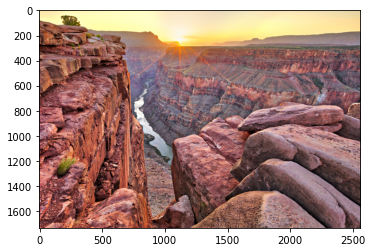

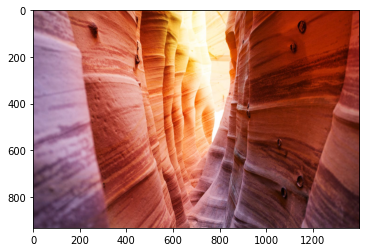

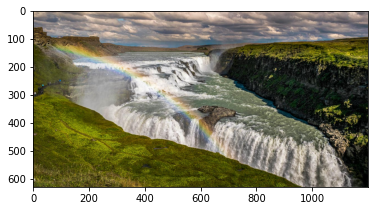

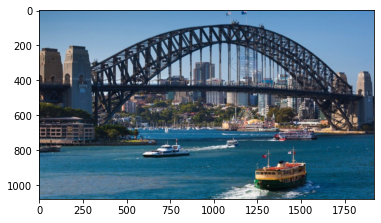

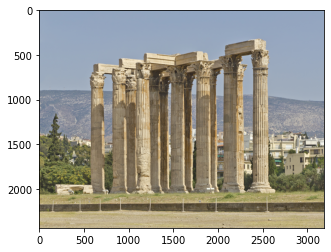

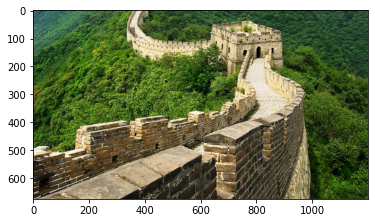

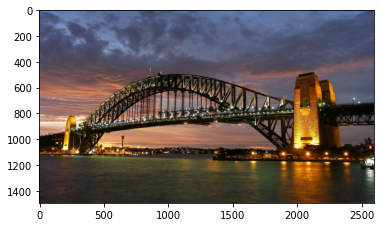

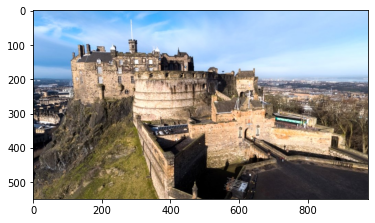

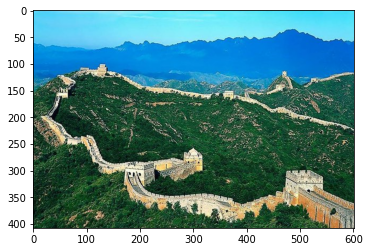

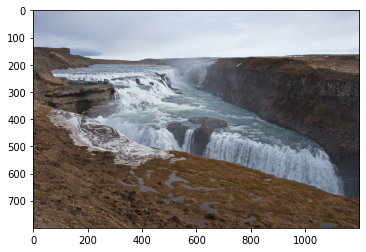

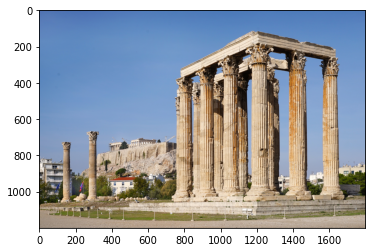

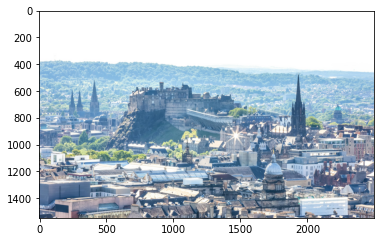

In [24]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import glob
image_list = glob.glob('test_landmark_photos/*.jpg')
for _id, _image_path in enumerate(image_list):
    print(f'---\nImage from <{_image_path}>')
    suggest_locations(_image_path, fig_id=_id)